In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
import optuna

In [5]:
df = pd.read_csv("/content/hmeq.csv")
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# 1. Data preparation
***Xử lý missing value***
- Với numerical variable, thay thế missing value bằng Mean
- Với categorical variable, thay thế missing value bằng Mode

In [6]:
df.isnull().sum()

,0
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580
CLAGE,308


In [7]:
numeric_cols = df.select_dtypes(include=['number']).columns

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

In [8]:
cate_cols = df.select_dtypes(include=['object']).columns

for col in cate_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
df.isnull().sum()

,0
BAD,0
LOAN,0
MORTDUE,0
VALUE,0
REASON,0
JOB,0
YOJ,0
DEROG,0
DELINQ,0
CLAGE,0


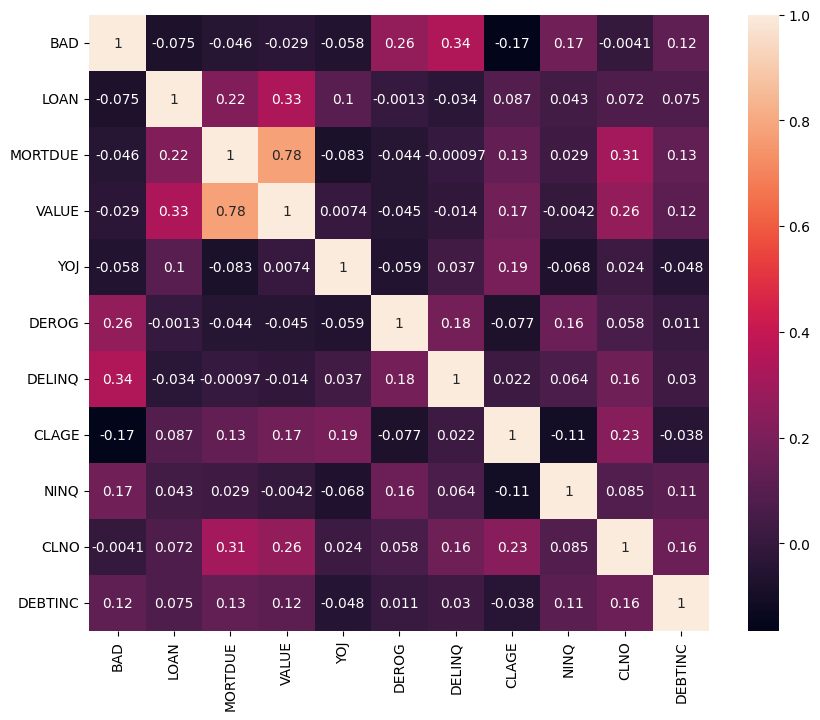

In [10]:
corr_matrix = df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot = True)
plt.show()

***Chia train-val-test***

In [11]:
from sklearn.model_selection import train_test_split

# 64%-16%-20%
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

# 2. Mô hình

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

***Xử lý biến phân loại trước khi đưa vào mô hình Random Forest bằng Target Encoding***

In [13]:
target_mean_REASON = train.groupby('REASON')['BAD'].mean()
target_mean_JOB = train.groupby('JOB')['BAD'].mean()

In [ ]:
train_rf = train.copy()
val_rf = val.copy()
test_rf = test.copy()

In [ ]:
train_rf['REASON'] = train_rf['REASON'].map(target_mean_REASON).fillna(target_mean_REASON.mean())
train_rf['JOB'] = train_rf['JOB'].map(target_mean_JOB).fillna(target_mean_JOB.mean())

val_rf['REASON'] = val_rf['REASON'].map(target_mean_REASON).fillna(target_mean_REASON.mean())
val_rf['JOB'] = val_rf['JOB'].map(target_mean_JOB).fillna(target_mean_JOB.mean())

test_rf['REASON'] = test_rf['REASON'].map(target_mean_REASON).fillna(target_mean_REASON.mean())
test_rf['JOB'] = test_rf['JOB'].map(target_mean_JOB).fillna(target_mean_JOB.mean())

In [ ]:
X_train_rf = train_rf.drop(['BAD'], axis='columns')
y_train_rf = train_rf['BAD']

X_val_rf = val_rf.drop(['BAD'], axis='columns')
y_val_rf = val_rf['BAD']

X_test_rf = test_rf.drop(['BAD'], axis='columns')
y_test_rf = test_rf['BAD']

***Tối ưu hóa bộ siêu tham số***

In [ ]:
def objective(trial):
    '''
    Parameter:
       trial: represents each attempt with a different set of hyperparameter values for the model

    Return: F1-score on the validation set after training the model
    '''
    # Hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Initialize the Random Forest model with hyperparameters from the trial
    model_rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Train model
    model_rf.fit(X_train_rf, y_train_rf)

    # Predict
    y_val_pred = model_rf.predict(X_val_rf)

    # Calculate F1-score
    f1 = f1_score(y_val_rf, y_val_pred)

    return f1

In [ ]:
# Create Optuna study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best result
print("Best hyperparameters: ", study.best_trial.params)
print("Best F1-score: ", study.best_value)

[I 2025-01-15 15:48:18,321] A new study created in memory with name: no-name-fb7ffdff-052c-4f6d-9676-8b8338e266cc
[I 2025-01-15 15:48:19,640] Trial 0 finished with value: 0.4946236559139785 and parameters: {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4946236559139785.
[I 2025-01-15 15:48:27,815] Trial 1 finished with value: 0.6226415094339622 and parameters: {'n_estimators': 900, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 1 with value: 0.6226415094339622.
[I 2025-01-15 15:48:38,430] Trial 2 finished with value: 0.5844155844155844 and parameters: {'n_estimators': 850, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6226415094339622.
[I 2025-01-15 15:48:45,625] Trial 3 finished with value: 0.6329113924050633 and parameters: {'n_estimators': 550, 'max_depth': 11, 

Best hyperparameters:  {'n_estimators': 650, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': None}
Best F1-score:  0.7262569832402235


In [ ]:
model_rf = RandomForestClassifier(
        n_estimators=650,
        max_depth=13,
        min_samples_split=14,
        min_samples_leaf=3,
        max_features=None,
        random_state=42
    )

model_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=13, max_features=None, min_samples_leaf=3,
                       min_samples_split=14, n_estimators=650, random_state=42)

***Confusion matrix***

In [ ]:
y_train_pred = model_rf.predict(X_train_rf)
y_val_pred = model_rf.predict(X_val_rf)
y_test_pred = model_rf.predict(X_test_rf)

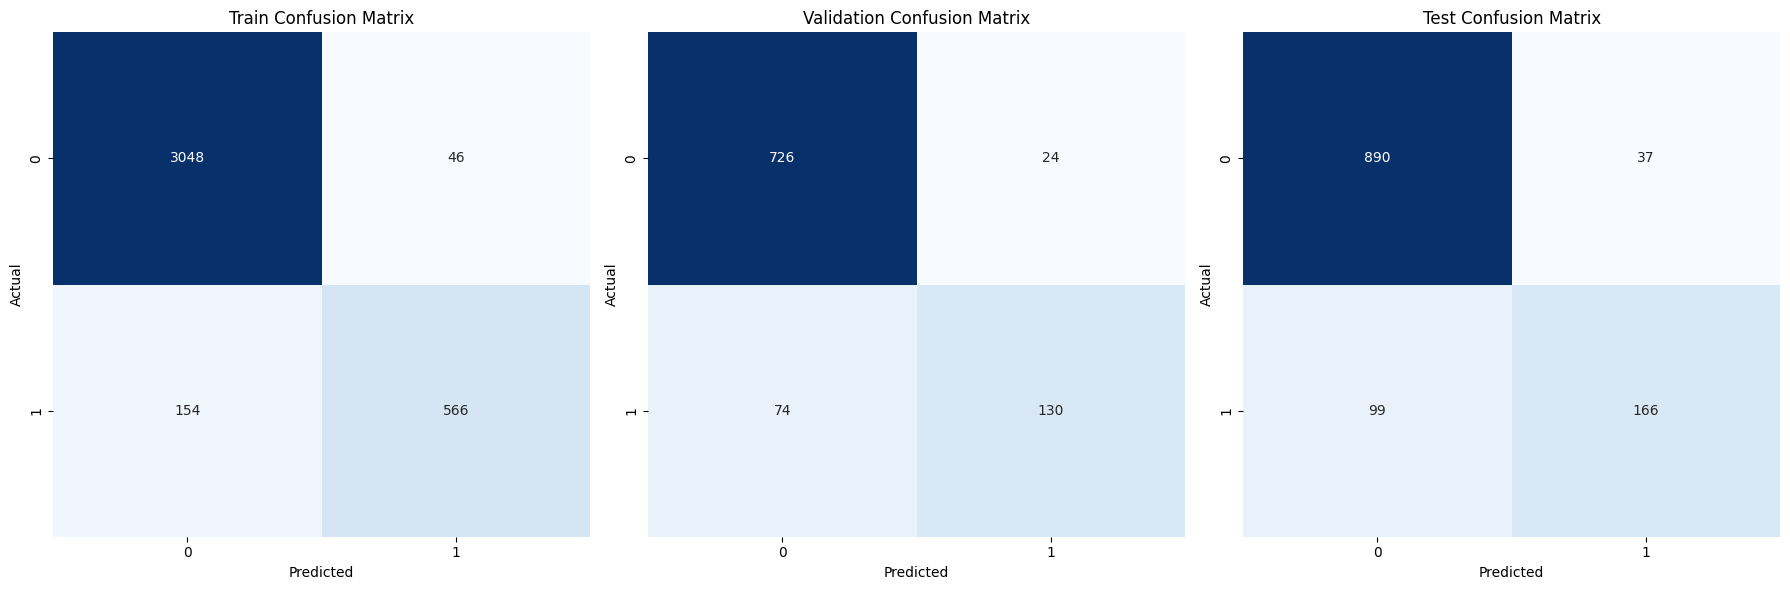

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Calculate confusion matrix for each dataset
cm_train = confusion_matrix(y_train_rf, y_train_pred)
cm_val = confusion_matrix(y_val_rf, y_val_pred)
cm_test = confusion_matrix(y_test_rf, y_test_pred)

# Plot heatmap for each confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Train Confusion Matrix')

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Validation Confusion Matrix')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Test Confusion Matrix')

#Show plot
plt.tight_layout()
plt.show()

In [ ]:
print("F1-score của tập train: ", f1_score(y_train_rf, y_train_pred))
print("F1-score của tập val: ", f1_score(y_val_rf, y_val_pred))
print("F1-score của tập test: ", f1_score(y_test_rf, y_test_pred))

F1-score của tập train:  0.8498498498498499
F1-score của tập val:  0.7262569832402235
F1-score của tập test:  0.7094017094017094


## CatBoost

In [14]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [15]:
from catboost import CatBoostClassifier

In [16]:
X_train_cb = train.drop(['BAD'], axis='columns')
y_train_cb = train['BAD']

X_val_cb = val.drop(['BAD'], axis='columns')
y_val_cb = val['BAD']

X_test_cb = test.drop(['BAD'], axis='columns')
y_test_cb = test['BAD']

In [ ]:
def objective(trial):

    iterations=trial.suggest_int('iterations', 100, 1000, step = 50)
    depth=trial.suggest_int('depth', 4, 10)
    learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2, step = 0.01)
    l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1, 10, step=0.5)
    bagging_temperature=trial.suggest_float('bagging_temperature', 0, 1, step=0.1)

    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        cat_features=[3, 4],
        verbose=0,
        random_state=42,
    )

    # Train model
    model.fit(X_train_cb, y_train_cb)

    # Predict
    y_val_pred = model.predict(X_val_cb)

    # F1-score
    f1 = f1_score(y_val_cb, y_val_pred)

    return f1

In [ ]:
# Create Optuna study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best result
print("Best hyperparameters: ", study.best_trial.params)
print("Best F1-score: ", study.best_value)

[I 2025-01-15 16:59:37,929] A new study created in memory with name: no-name-8c04df2e-1256-4009-90b7-8850d53d3917
[I 2025-01-15 16:59:52,435] Trial 0 finished with value: 0.8135593220338984 and parameters: {'iterations': 750, 'depth': 9, 'learning_rate': 0.18000000000000002, 'l2_leaf_reg': 4.0, 'bagging_temperature': 0.30000000000000004}. Best is trial 0 with value: 0.8135593220338984.
[I 2025-01-15 16:59:59,142] Trial 1 finished with value: 0.7808988764044944 and parameters: {'iterations': 1000, 'depth': 5, 'learning_rate': 0.13, 'l2_leaf_reg': 9.5, 'bagging_temperature': 0.4}. Best is trial 0 with value: 0.8135593220338984.
[I 2025-01-15 17:00:14,870] Trial 2 finished with value: 0.8112676056338028 and parameters: {'iterations': 650, 'depth': 10, 'learning_rate': 0.2, 'l2_leaf_reg': 6.5, 'bagging_temperature': 0.4}. Best is trial 0 with value: 0.8135593220338984.
[I 2025-01-15 17:00:38,408] Trial 3 finished with value: 0.8011204481792717 and parameters: {'iterations': 950, 'depth': 1

Best hyperparameters:  {'iterations': 850, 'depth': 10, 'learning_rate': 0.13, 'l2_leaf_reg': 2.0, 'bagging_temperature': 0.6000000000000001}
Best F1-score:  0.8225352112676056


In [17]:
model_cb = CatBoostClassifier(
        iterations=850,
        depth=10,
        learning_rate=0.13,
        cat_features=[3, 4],
        l2_leaf_reg=2,
        bagging_temperature=0.6,
        random_state=42,
        verbose=0
    )

model_cb.fit(X_train_cb, y_train_cb)

In [18]:
y_train_pred = model_cb.predict(X_train_cb)
y_val_pred = model_cb.predict(X_val_cb)
y_test_pred = model_cb.predict(X_test_cb)

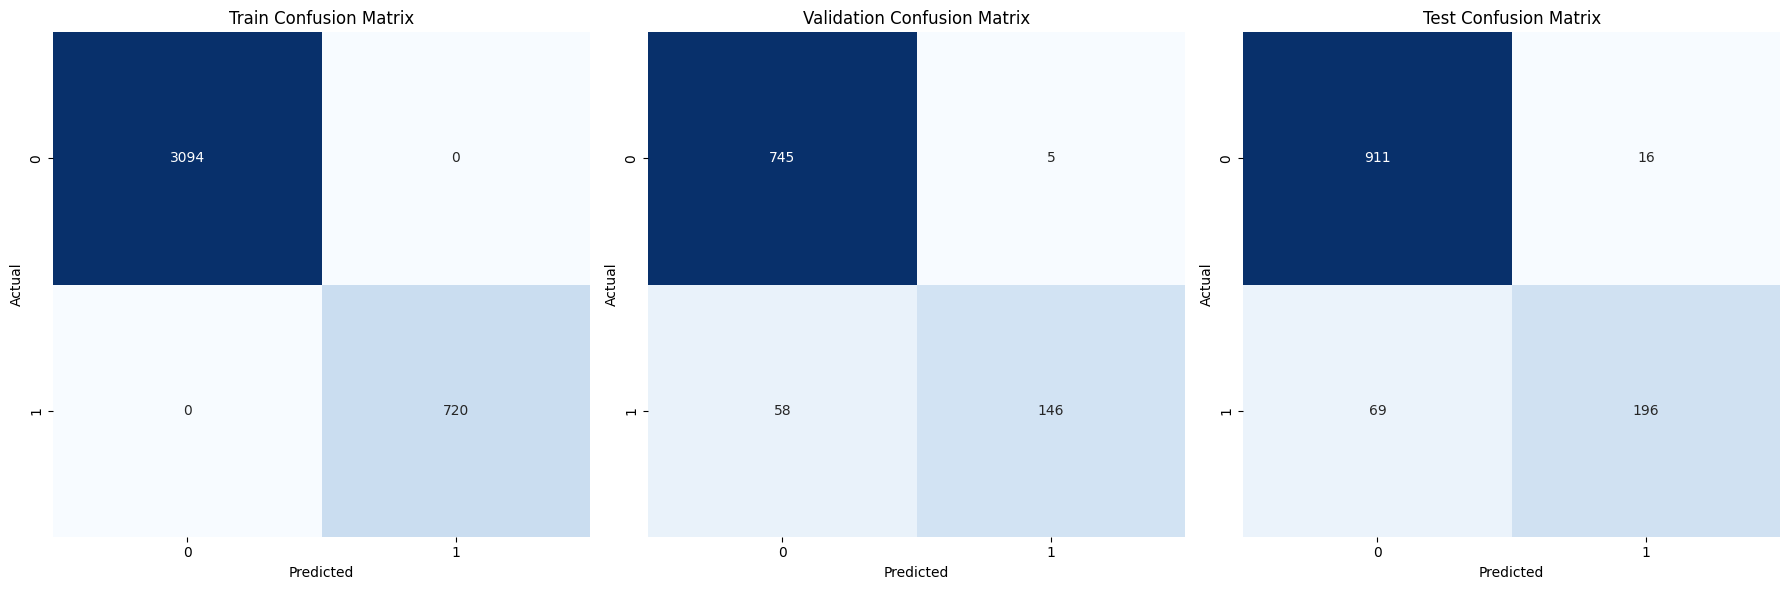

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Calculate confusion matrix for each dataset
cm_train = confusion_matrix(y_train_cb, y_train_pred)
cm_val = confusion_matrix(y_val_cb, y_val_pred)
cm_test = confusion_matrix(y_test_cb, y_test_pred)

# Plot heatmap for each confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Train Confusion Matrix')

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Validation Confusion Matrix')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Test Confusion Matrix')

#Show plot
plt.tight_layout()
plt.show()

In [ ]:
print("F1-score của tập train: ", f1_score(y_train_cb, y_train_pred))
print("F1-score của tập val: ", f1_score(y_val_cb, y_val_pred))
print("F1-score của tập test: ", f1_score(y_test_cb, y_test_pred))

F1-score của tập train:  1.0
F1-score của tập val:  0.8225352112676056
F1-score của tập test:  0.8218029350104822


*Dựa trên chỉ số F1-score, có thể thấy mô hình CatBoost có hiệu suất dự báo tốt hơn đáng kể so với mô hình RandomForest*

***Kiểm định mô hình bằng ROC-AUC và chỉ số Gini***

In [20]:
auc = roc_auc_score(y_test_cb, y_test_pred)
gini = 2 * auc - 1

In [21]:
fpr, tpr, _ = roc_curve(y_test_cb, y_test_pred)

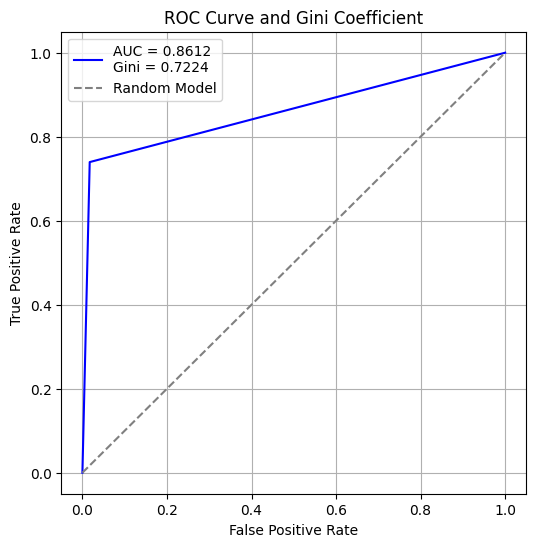

In [26]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}\nGini = {gini:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve and Gini Coefficient")
plt.legend()
plt.grid()
plt.show()

*AUC>0.8 và Gini>0.6 cho thấy mô hình CatBoost được sử dụng là mô hình có khả năng dự báo tốt***

***Feature Importance***

In [ ]:
importances = model_cb.feature_importances_
indices = np.argsort(importances)[::-1]

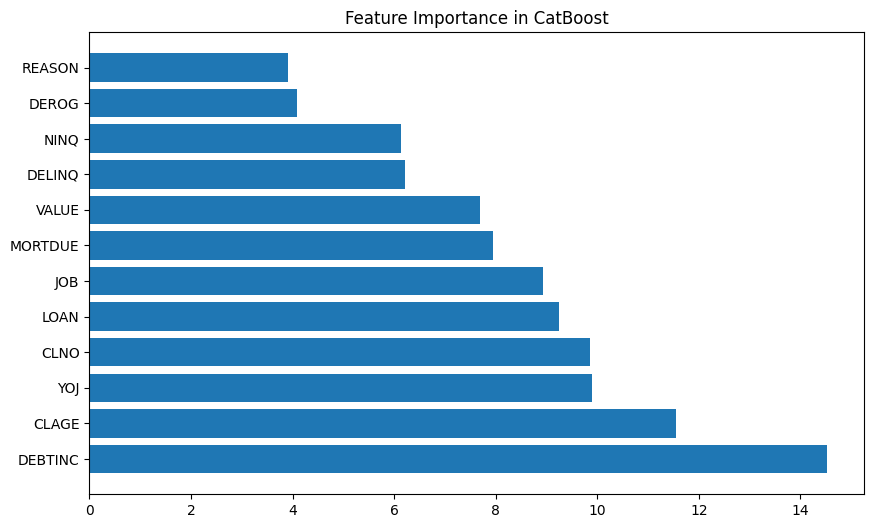

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [X_train_cb.columns[i] for i in indices])
plt.title('Feature Importance in CatBoost')
plt.show()